In [2]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
from collections import Counter

In [3]:
# Load the dataset
data1 = pd.read_csv("D:\kcc_dataset.csv")
print(data1)


<>:2: SyntaxWarning: invalid escape sequence '\k'
<>:2: SyntaxWarning: invalid escape sequence '\k'
C:\Users\Admin\AppData\Local\Temp\ipykernel_12168\3936404600.py:2: SyntaxWarning: invalid escape sequence '\k'
  data1 = pd.read_csv("D:\kcc_dataset.csv")
C:\Users\Admin\AppData\Local\Temp\ipykernel_12168\3936404600.py:2: DtypeWarning: Columns (1,8) have mixed types. Specify dtype option on import or set low_memory=False.
  data1 = pd.read_csv("D:\kcc_dataset.csv")


              BlockName Category  Year  Month  Day    Crop DistrictName  \
0                  0           0  2006      1   17    1275        SAGAR   
1                  0           0  2006      1   17     964        SAGAR   
2                  0           0  2006      1   17    1279        SAGAR   
3                  0           0  2006      1   17    1064        SAGAR   
4                  0           0  2006      1   17    1279        DAMOH   
...                 ...      ...   ...    ...  ...     ...          ...   
40774827       CHAWNGTE   Others  2024      8   19  Others    LAWNGTLAI   
40774828       CHAWNGTE   Others  2024      8   19  Others    LAWNGTLAI   
40774829       CHAWNGTE   Others  2024      8   19  Others    LAWNGTLAI   
40774830       CHAWNGTE   Others  2024      8   19  Others    LAWNGTLAI   
40774831  WEST PHAILENG   Others  2024      8   19  Others        MAMIT   

                   QueryType Season            Sector       StateName  \
0                         

In [4]:
# Filter the dataset
f_df = data1[(data1['Crop'].str.isnumeric() == False) & (data1['Crop'] != 'Others') & 
             (data1['QueryType'].str.isnumeric() == False) & (data1['QueryType'] != 'Others')]
data = pd.DataFrame(f_df)
data = data[data['Year'] >= 2013]
data = data[['Month', 'Year', 'StateName', 'DistrictName', 'Crop', 'QueryType']]



In [5]:
# Create a new feature 'Crop_QueryType'
data["Crop_QueryType"] = data['Crop'] + '_' + data['QueryType']
data["Place"]= data['StateName'] + '_' + data['DistrictName']

In [6]:
print(data)

          Month  Year       StateName               DistrictName  \
3039763       1  2013  ANDHRA PRADESH                 SRIKAKULAM   
3039867       2  2013  ANDHRA PRADESH                 SRIKAKULAM   
3039869       2  2013  ANDHRA PRADESH                 SRIKAKULAM   
3040001       4  2013  ANDHRA PRADESH                 SRIKAKULAM   
3040002       4  2013  ANDHRA PRADESH                 SRIKAKULAM   
...         ...   ...             ...                        ...   
40774809      8  2024           DELHI  New Delhi Connaught Place   
40774810      8  2024           DELHI  New Delhi Connaught Place   
40774813      8  2024           DELHI  New Delhi Connaught Place   
40774814      8  2024           DELHI  New Delhi Connaught Place   
40774815      8  2024           DELHI  New Delhi Connaught Place   

                                  Crop                        QueryType  \
3039763           Sunflower suryamukhi                 Water Management   
3039867   Groundnut pea nutmung p

In [7]:
# Initialize LLM-based embedding model (e.g., SentenceTransformers)
model = SentenceTransformer('all-MiniLM-L6-v2')  # Efficient for large data


In [8]:
# Generate embeddings for Crop_QueryType
data['Embeddings'] = data['Crop_QueryType'].apply(lambda x: model.encode(x))

# Aggregate embeddings by Place and Month
grouped = data.groupby(['Place', 'Month'])['Embeddings'].apply(np.mean).reset_index()


c:\Users\Admin\anaconda3\Lib\site-packages\transformers\models\bert\modeling_bert.py:440: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


In [9]:
print(data)
print(grouped)

          Month  Year       StateName               DistrictName  \
3039763       1  2013  ANDHRA PRADESH                 SRIKAKULAM   
3039867       2  2013  ANDHRA PRADESH                 SRIKAKULAM   
3039869       2  2013  ANDHRA PRADESH                 SRIKAKULAM   
3040001       4  2013  ANDHRA PRADESH                 SRIKAKULAM   
3040002       4  2013  ANDHRA PRADESH                 SRIKAKULAM   
...         ...   ...             ...                        ...   
40774809      8  2024           DELHI  New Delhi Connaught Place   
40774810      8  2024           DELHI  New Delhi Connaught Place   
40774813      8  2024           DELHI  New Delhi Connaught Place   
40774814      8  2024           DELHI  New Delhi Connaught Place   
40774815      8  2024           DELHI  New Delhi Connaught Place   

                                  Crop                        QueryType  \
3039763           Sunflower suryamukhi                 Water Management   
3039867   Groundnut pea nutmung p

In [10]:
# Perform clustering on embeddings
embeddings_matrix = np.vstack(grouped['Embeddings'].values)
kmeans = KMeans(n_clusters=4, random_state=42)
grouped['Cluster'] = kmeans.fit_predict(embeddings_matrix)

# Assign clusters back to the original data
data = data.merge(grouped[['Place', 'Month', 'Cluster']], on=['Place', 'Month'])


In [12]:
# Find the top 3 Crop_QueryTypes for each cluster
cluster_top_queries = {}
for cluster in range(4):
    cluster_data = data[data['Cluster'] == cluster]
    crop_query_counts = Counter(cluster_data['Crop_QueryType'])
    top_10_queries = crop_query_counts.most_common(10)
    cluster_top_queries[cluster] = [query[0] for query in top_10_queries]

# Save clustering results and top queries to a CSV
output_data = grouped[['Place', 'Month', 'Cluster']]
output_data.to_csv("D:/clustering_results.csv", index=False)


In [13]:
# Save top queries for each cluster
top_queries_df = pd.DataFrame(cluster_top_queries.items(), columns=['Cluster', 'Top_Crop_QueryTypes'])
top_queries_df.to_csv("D:/top_crop_querytypes_per_cluster.csv", index=False)

print("Clustering and analysis completed. Results saved to CSV files.")


Clustering and analysis completed. Results saved to CSV files.


In [14]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Reduce dimensions of embeddings to 2D for visualization
def reduce_dimensions(embeddings, method='pca', n_components=2):
    if method == 'pca':
        reducer = PCA(n_components=n_components, random_state=42)
    elif method == 'tsne':
        reducer = TSNE(n_components=n_components, random_state=42, perplexity=30)
    else:
        raise ValueError("Invalid method. Choose either 'pca' or 'tsne'.")
    reduced = reducer.fit_transform(embeddings)
    return reduced


In [15]:
# Get embeddings matrix and cluster labels
embeddings_matrix = np.vstack(grouped['Embeddings'].values)
clusters = grouped['Cluster'].values

# Reduce dimensions
reduced_embeddings = reduce_dimensions(embeddings_matrix, method='pca')  # Use 'tsne' for t-SNE

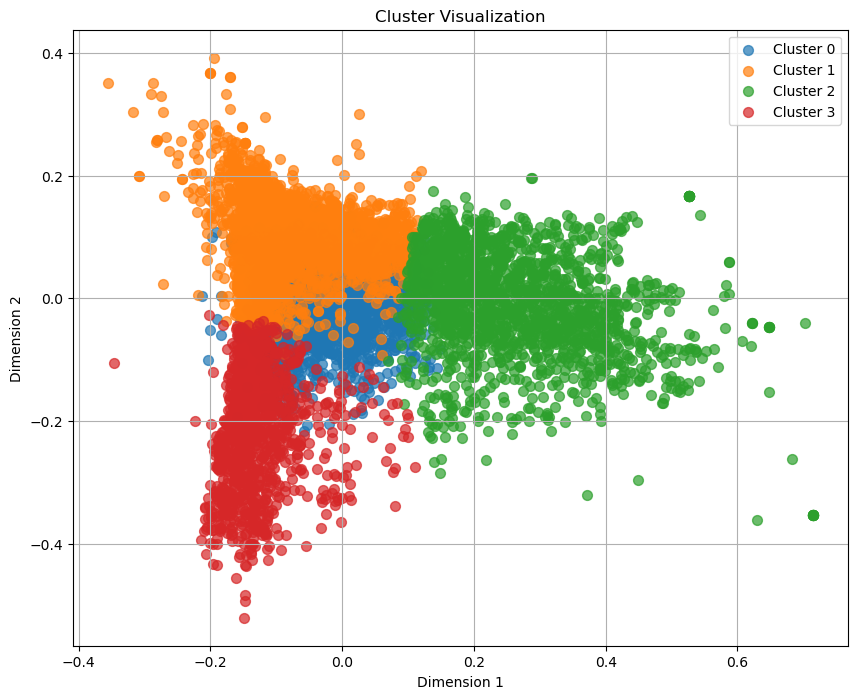

In [ ]:
# Plot clusters
plt.figure(figsize=(10, 8))
for cluster in range(4):
    cluster_points = reduced_embeddings[clusters == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster}", s=50, alpha=0.7)

plt.title("Cluster Visualization")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend()
plt.grid(True)
plt.show()

In [17]:
from scipy.stats import mode

# Calculate the mode cluster for each place
place_cluster_mode = (
    grouped.groupby('Place')['Cluster']
    .agg(lambda x: mode(x)[0][0] if isinstance(mode(x)[0], np.ndarray) else mode(x)[0])  # Handle both cases
    .reset_index()
    # .rename(columns={'Cluster': 'Mode_Cluster'})
)


In [18]:
# Save to CSV
place_cluster_mode.to_csv("D:/data paper/place_mode_cluster.csv", index=False)

In [19]:
# Merge mode cluster information with embeddings
place_embeddings = (
    grouped.groupby('Place')['Embeddings']
    .apply(np.mean)  # Aggregate embeddings for each place
    .reset_index()
    .merge(place_cluster_mode, on='Place')
)
print(place_embeddings)

                                        Place  \
0                     A AND N ISLANDS_NICOBAR   
1    A AND N ISLANDS_NORTH AND MIDDLE ANDAMAN   
2               A AND N ISLANDS_SOUTH ANDAMAN   
3                     ANDHRA PRADESH_ANANTPUR   
4                     ANDHRA PRADESH_CHITTOOR   
..                                        ...   
677                WEST BENGAL_North DINAJPUR   
678                       WEST BENGAL_PURULIA   
679             WEST BENGAL_SOUTH 24 PARGANAS   
680                WEST BENGAL_South DINAJPUR   
681                WEST BENGAL_WEST MEDINIPUR   

                                            Embeddings  Cluster  
0    [-0.038282216, 0.025313318, -0.02998875, -0.00...        2  
1    [-0.06414812, 0.052719865, -0.026420413, -0.01...        1  
2    [-0.049649574, 0.05619387, -0.024730228, -0.01...        1  
3    [-0.05808474, 0.0516156, -0.0076788333, 0.0080...        0  
4    [-0.060937826, 0.060709596, -0.01997838, -0.00...        1  
..             

In [20]:
# Reduce dimensions of embeddings to 2D for visualization
embeddings_matrix = np.vstack(place_embeddings['Embeddings'].values)
mode_clusters = place_embeddings['Cluster'].values
reduced_embeddings = reduce_dimensions(embeddings_matrix, method='pca')  # Or method='tsne'


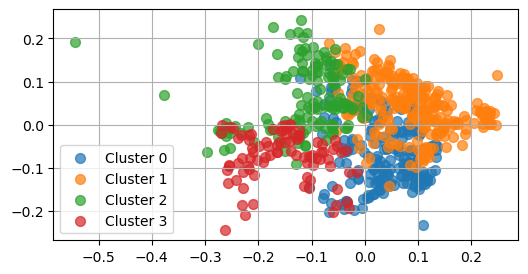

In [21]:
# Plot mode-based clusters
plt.figure(figsize=(6,3))
for cluster in range(4):
    cluster_points = reduced_embeddings[mode_clusters == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster}", s=50, alpha=0.7)

# plt.title("Cluster Visualization Based on Place")
# plt.xlabel("Dimension 1")
# plt.ylabel("Dimension 2")
plt.legend()
plt.grid(True)
plt.show()

In [28]:
# Example: Add synthetic ground truth labels for demonstration
data['TrueLabel'] = np.random.randint(0, 4, size=len(data))

In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [29]:
data = data.merge(grouped[['Place', 'Month', 'Cluster']], on=['Place', 'Month'])


In [30]:
# Calculate metrics
true_labels = data['TrueLabel']
predicted_labels = data['Cluster']

In [ ]:
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')  # Use 'weighted' for multi-class
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.2501
Precision: 0.2501
Recall: 0.2501
F1-Score: 0.2458
